# **Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title  { display-mode: "form" }
#@title  { display-mode: "form" }
#@title  { vertical-output: true, display-mode: "form" }
#@markdown Select The Best

use_pearson_corr = "False" #@param ["True", "False"]
Data_to_use = "6_bands" #@param ["6_bands", "65_bands", "372_bands", "Planet_hisar", "Pavia", "Indian_Pines", "Hisar_sentinel"]
use_pearson_corr = True if use_pearson_corr in [True, "True"] else False
P_S = "9"  #@param [3, 9, 15, 21]

P_S = int(P_S)
Targeted_accuracy = "0.985" #@param [0.97, 0.98, 0.985, 0.99, 0.995]
Min_trainable_epoch = 20 #@param [20, 25, 30, 35, 40, 50, 100]

train_percent = 75                  #@param [75, 80, 90]
epoch = 100                         #@param [100, 200, 300, 400, 500]

LR_START = 3e-3
LR_MAX = 6e-3
LR_MIN = 1e-5

batch_size = 128
BATCH_SIZE = 128
dropout_rate = "0.25"                 #@param [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

P_S = int(P_S)
epoch = int(epoch)
Min_trainable_epoch = int(Min_trainable_epoch)
Targeted_accuracy = float(Targeted_accuracy)
train_percent = int(train_percent)
dropout_rate = float(dropout_rate)
shifts = int(1/dropout_rate)
assert epoch >= Min_trainable_epoch/dropout_rate, f"For Min_trainable_epoch: {Min_trainable_epoch} & dropout_rate: {dropout_rate}, minimum number of `epoch` should be {Min_trainable_epoch/dropout_rate}"

In [ ]:
!pip install spectral
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 10.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.stats as st
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import warnings
import math
import os
import gc

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.util.tf_export import keras_export
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Add, Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Lambda
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, add, multiply
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2

import spectral

np.random.seed(1337)          # to get reproducible results
base_path = "/content/drive/MyDrive/m_p/Uncertainty in Models/CNN Models/AlexNet/"

try:
    os.mkdir(base_path)
except:
    pass

try:
    os.mkdir(base_path + "With Pearson correlation/") if use_pearson_corr else os.mkdir(base_path + "Without Pearson correlation/")
except:
    pass

if use_pearson_corr:
    folder_path = base_path + "With Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass
else:
    folder_path = base_path + "Without Pearson correlation/" + str(Data_to_use) + "/"
    try:
        os.mkdir(folder_path)
    except:
        pass

In [ ]:
try:
    os.mkdir(folder_path + "Trained models")
    os.mkdir(folder_path + "Results")
except:
    pass

In [ ]:
Normalize_data = True
if Data_to_use == "6_bands":
    H, W, B = 330, 307, 6
    x = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/data.csv'))
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/multispectral/ref.csv'))

if Data_to_use == "65_bands":
    H, W, B = 512, 512, 65
    x = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS.mat')['DIAS']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Dias/DIAS_ref.mat')['DIAS_ref']

if Data_to_use == "372_bands":
    H, W, B = 1101, 566, 372
    x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']
    y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    Normalize_data = False
    #x = x[:, selective_bands]

if Data_to_use == "Planet_hisar":
    H, W, B = 1733, 2647, 4
    x = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planet.csv', header=None)
    y = pd.read_csv('/content/drive/My Drive/m_p/data/planet_data_hisar/planetgt.csv', header=None)

if Data_to_use == "Pavia":
    H, W, B = 610, 340, 103
    x = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni.mat')['paviaU']
    y = si.loadmat('/content/drive/MyDrive/m_p/data/pavia/paviauni_gt.mat')['paviaU_gt']

if Data_to_use == "Indian_Pines":
    H, W, B = 145, 145, 220
    x = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines.mat')['indian_pines']
    y = si.loadmat('/content/drive/My Drive/m_p/data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt']

if Data_to_use == "Hisar_sentinel":
    H, W, B = 722, 1014, 4
    x = np.array(si.loadmat('/content/drive/My Drive/m_p/data/Hissar_25%/datas.mat')['datas'])
    y = np.array(pd.read_csv('/content/drive/My Drive/m_p/data/Hissar_25%/fullgt.csv'))

y_shape = np.array(y).shape[0]
x, y = np.array(x).reshape(H,W,B), np.array(y).reshape(H,W)
x = x.astype('float16')
#########
print("minimum value in raw data is :", x.min())
print("maximum value in raw data is :", x.max(), "\n")
print("shape of raw data: ", x.shape)
print("shape of target data: ", y.shape, "\n")

# Normalizing the data between 0,1
if Normalize_data:
    for i in range(B):
        band_min = x[:,:,i].min()
        band_max = x[:,:,i].max()
        band_range = band_max - band_min
        x[:,:,i] = (x[:,:,i] - band_min)/band_range

minimum value in raw data is : 12.0
maximum value in raw data is : 209.0 

shape of raw data:  (330, 307, 6)
shape of target data:  (330, 307) 



In [ ]:
pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

num_classes = len(np.unique(y))-1
Approximate_rgb_img = x[:,:,[B//2-1, B//2, B//2+1]]*255

print()
print("minimum value in x is :", x.min())
print("maximum value in x is :", x.max())
print()
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)
print()
print("shape of padded_x: ", padded_x.shape, "\n")
print(f"{len(Y)*100/y_shape:.4f}% of data is labeled with {num_classes} classes")


minimum value in x is : 0.0
maximum value in x is : 1.0

shape of x:  (330, 307, 6)
shape of y:  (330, 307)

shape of padded_x:  (338, 315, 6) 

17.0161% of data is labeled with 7 classes


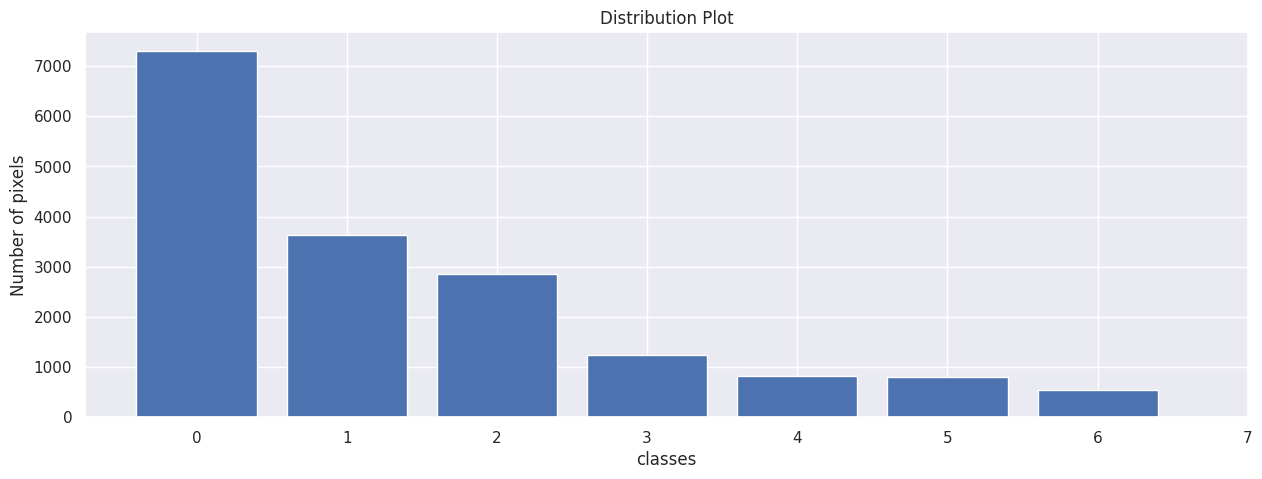

In [ ]:
class_labels, value_counts = np.unique(y.reshape(-1,1), return_counts = True)
plt.figure(figsize = (15,5))
plt.bar(class_labels[1:]-1, value_counts[1:])
plt.xticks(class_labels, rotation = 0)
plt.xlabel("classes")
plt.ylabel("Number of pixels")
plt.title("Distribution Plot")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
print(f"x_train: {x_train.shape} \nx_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}")

x_train: (12929, 9, 9, 6) 
x_test: (4310, 9, 9, 6) 
y_train: (12929,) 
y_test: (4310,)


In [ ]:
# del x, X, Y
gc.collect()

3484

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    y_hat = np.zeros((H,W_range))
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        prob = model.predict(patchs, verbose = -1)
        # y_pred = np.argmax(prob,axis=1)+1
        y_prob[:,j,:] = prob
        y_hat[:,j] = np.argmax(prob,axis=1)+1
        del patchs, prob
        gc.collect()
    return y_hat, y_prob


def predict_image(model, padded_x, H, W, B, P_S, num_classes):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_prob = np.zeros((H,W, num_classes))
    y_hat[:,:W//2], y_prob[:,:W//2,:] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S, num_classes)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:], y_prob[:,W//2:,:] = predict_half_image(model, padded_x_2nd_half, H, width, B, P_S, num_classes)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    y_prob = np.reshape(y_prob, (H, W, num_classes))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat, y_prob

In [ ]:
def predict_half_image_prob(model, padded_x, H, W_range, B, P_S):
    y_prob = np.zeros((H, W_range, num_classes))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred_prob = model.predict(patchs, verbose = -1)
        y_prob[:,j,:] = y_pred_prob
        del patchs, y_pred_prob
        gc.collect()
    return y_prob

def probabilistic_outputs(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W, num_classes))
    y_hat[:,:W//2,:] = predict_half_image_prob(model, padded_x_1st_half, H, W//2, B, P_S)
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    width = W//2 if W//2 == W/2 else W//2+1
    y_hat[:,W//2:,:] = predict_half_image_prob(model, padded_x_2nd_half, H, width, B, P_S)
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec:.2f} sec.')
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def predict(model, x_test):
    y_pred = np.argmax(model.predict(x_test, verbose = -1), axis = -1)
    return y_pred

In [ ]:
def plot_accuracy_loss_curve(history, use_pearson_corr = None, folder_path = None):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='blue', marker='o', linewidth=1.5, markersize = 2,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=1.5, markersize = 2, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'black', marker='o', linewidth=1.5, markersize = 2, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=1.5, markersize = 2, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        results_dir = os.path.join(folder_path, "Results")
        os.makedirs(results_dir, exist_ok=True) # Create the directory if it doesn't exist
        if use_pearson_corr:
            path = os.path.join(results_dir, "Pearson_Corr " + str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png")
        else:
            path = os.path.join(results_dir, str(train_percent) + "% ps_"+ str(P_S) + " accuracy_loss.png")
        fig.savefig(path)

In [ ]:
def performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = None):
    Total_params, Trainable_params, Non_trainable_params = parameters_summary
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "Training Time: " : [tt]}).T
    df_summary = pd.DataFrame({'Total_params: ': [Total_params], 'Trainable_params: ' : [Trainable_params], 'Non_trainable_params: ':[Non_trainable_params]}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2, width_ratios=[1,3], wspace = 0.5, hspace = 0.5, height_ratios=[7,1])

    fig = plt.figure(figsize = (24,10))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)
    ax3.set_xticks([])

    ax4 = fig.add_subplot(spec[3])
    sns.heatmap(df_summary, cmap = "Blues", cbar = False, annot = True, fmt=' .10g', ax = ax4)
    ax4.set_xticks([])

    if folder_path:
        path = folder_path + "Results/" + str(train_percent) + "% ps_" + str(P_S) +" Performance Measure.png"
        fig.savefig(path)

In [ ]:
def measure_uncertainty(model, x_test, y_test):
    y_prob = model.predict(x_test, verbose = -1)

    """Sorting is as follow
    y_prob = [[11 12 13 22]
              [31 10 33  7]
              [21  7 23 14]]

    temp_prob will sort the y_prob along rows
    temp_prob = [[11 12 13 22]
                 [7  10 31 33]
                 [7  14 21 23]]

    Now sort the y_prob based on the last column of temp_pred i.e. last col is [22, 33, 23] and sorting will be [22, 23, 33] ---> [0, 2, 1]
     y_prob = [[11 12 13 22]
               [21  7 23 14]
               [31 10 33  7]]
    """
    temp_pred = np.sort(y_prob, axis = -1)      # sort the probabilities along rows. Higher prob values are along last column
    y_prob = y_prob[temp_pred[:,-1].argsort()]  # Arange the rows of predicted prob in assending position

    num = y_prob.shape[0]
    # observed = y_prob.max(axis = -1)
    observed = np.sort(y_prob, axis = -1)[:,-1]    # class predicted according to 1st maximum prob
    observed_1 = np.sort(y_prob, axis = -1)[:,-2]  # class predicted according to 2nd maximum prob
    observed_2 = np.sort(y_prob, axis = -1)[:,-3]  # class predicted according to 3rd maximum prob

    mean = y_prob.mean(axis = -1)
    std = y_prob.std(axis = -1)
    plt.figure(figsize = (24,8))
    plt.plot(np.arange(1, num+1, 1), observed - observed_1, color = "black", label = "certaintity")
    plt.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "observed")
    plt.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "observed_1")
    plt.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "observed_2")
    plt.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean")
    plt.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    plt.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    plt.legend()
    plt.title("Predictions based on normal model")
    plt.show()

In [ ]:
class Pearson_correlation_masked(layers.Layer):
    def __init__(self, P_S = 9, **kwargs):
        super(Pearson_correlation_masked, self).__init__(**kwargs)
        self.P_S = P_S

    def call(self, inputs):
        self.loc = (self.P_S)//2
        self.inputs = inputs
        self.channels = self.inputs.shape[-1]
        self.x_mean = tf.repeat(tf.math.reduce_mean(self.inputs, axis = -1, keepdims=True), repeats = self.channels, axis = -1)

        self.y = tf.repeat(tf.repeat(self.inputs[:,self.loc:self.loc+1, self.loc:self.loc+1, :], repeats = self.P_S, axis = -2), repeats = self.P_S, axis = -3)

        self.y_mean = tf.repeat(tf.math.reduce_mean(self.y, axis = -1, keepdims = True), repeats = self.channels, axis = -1)

        self.a = tf.math.subtract(self.inputs, self.x_mean)
        self.b = tf.math.subtract(self.y, self.y_mean)
        self.ab = tf.math.multiply(self.a,self.b)
        self.num = tf.math.reduce_sum(self.ab, axis = -1, keepdims = True)

        self.a_new = tf.math.reduce_sum(tf.math.multiply(self.a, self.a), axis = -1, keepdims = True)
        self.b_new = tf.math.reduce_sum(tf.math.multiply(self.b, self.b), axis = -1, keepdims = True)
        self.deno = tf.math.sqrt(tf.math.multiply(self.a_new, self.b_new))

        self.corr = tf.math.divide(self.num, self.deno)

        self.thresh = tf.math.reduce_mean(self.corr)
        self.mask = self.corr > self.thresh
        self.mask = tf.cast(self.mask, self.corr.dtype)

        self.masked_corr = tf.math.multiply(self.mask, self.corr)

        self.attention_weights = tf.repeat(self.masked_corr, repeats = self.channels, axis = -1)
        return multiply([self.inputs, self.attention_weights])

    def get_config(self, **kwargs):
        config = super(Pearson_correlation_masked, self).get_config()
        config.update({
            "P_S": self.P_S,
        })
        return config

In [ ]:
@keras_export('keras.layers.Dropout')
class Dropout_Train(layers.Layer):
    def __init__(self, rate, shift = 1, noise_shape=None, seed=None, **kwargs):
        super(Dropout_Train, self).__init__(**kwargs)

        if isinstance(rate, (int, float)) and not 0 <= rate <= 1:
            raise ValueError(f"Invalid value {rate} received for `rate`, expected a value between 0 and 1.")
        if type(shift) != int:
            raise TypeError(f"Invalid dtype {type(shift)} found for `shift`. It must be an integer")
        if shift*rate > 1.0:
            raise ValueError(f"Invalid value {shift} received for `shift`, expected an integer value less than or equal to {int(1/rate)}")
        self.rate = rate
        self.shift = shift
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return None

        concrete_inputs_shape = array_ops.shape(inputs)
        noise_shape = []
        for i, value in enumerate(self.noise_shape):
            noise_shape.append(concrete_inputs_shape[i] if value is None else value)
        return tf.convert_to_tensor(noise_shape)

    def call(self, inputs, training=None):
        if self.rate == 0:
            return tf.identity(inputs)

        if training is None:
            training = K.learning_phase()

        def dropped_inputs():
            input_shape = inputs.shape
            range_0 = int(self.rate*(self.shift-1)*input_shape[-1])
            if self.shift*self.rate < 1.0:
                range_1 = int(self.rate*(self.shift)*input_shape[-1])
            else:
                range_1 = None
            input_shape = inputs.shape
            multiplier = np.ones(input_shape[-1])
            multiplier[range_0:range_1] = 0.0
            multiplier = tf.constant(multiplier)
            return Multiply()([inputs, multiplier])

        output = control_flow_util.smart_cond(training, dropped_inputs, lambda: array_ops.identity(inputs))
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(Dropout_Train, self).get_config()
        config.update({
            "rate": self.rate,
            "shift": self.shift,
            "noise_shape": self.noise_shape,
            "seed": self.seed,
            "supports_masking": self.supports_masking
        })
        return config

In [ ]:
def modified_model(model, layer_name, rate, new_layer, shift, **kwargs):    # layer_name = "TRAIN_DROPOUT"
    name = kwargs["name"] if kwargs else None
    x = model.layers[0].output
    modification = False
    z = 0
    for lyr in model.layers[1:]:
        if (layer_name in lyr.name or layer_name in lyr.name.upper()) and (type(shift) != str):
            x = new_layer(rate = rate, shift = shift, name = layer_name + "_" + str(shift) + "_" + str(z))(x)
            modification = True
            z += 1
        elif (layer_name in lyr.name or layer_name in lyr.name.upper()) and (type(shift) == str):
            x = new_layer(rate = rate, name = layer_name + "_" + str(shift) + "_" + str(z))(x)
            z += 1
            modification = True
        else:
            x = lyr(x)
    if not modification:
        print("___________________________________Model has not been modified___________________________________")
    return Model(inputs = model.layers[0].input, outputs = x, name = name)

In [ ]:
class Custom_callbacks(tf.keras.callbacks.Callback):
    def __init__(self, filepath, epochs, rate, new_layer = Dropout_Train, layer_name = "DROPOUT", accuracy_score = 0.99, min_epochs = 50):
        super(Custom_callbacks, self).__init__()
        self.filepath = filepath
        self.epochs = epochs
        self.new_layer = new_layer
        self.rate = rate
        self.best = 0.0
        self.epoch_num = 1
        self.layer_name = layer_name
        self.min_epochs = min_epochs                    # minimum number of epochs that model should be trained in each shift
        self.accuracy_score = accuracy_score if accuracy_score <= 1.0 else accuracy_score/100.0

    def on_train_begin(self, logs=None):
        print(self.epochs)
        keys = list(logs.keys())
        self.shift = 1
        self.epoch_completed = 0
        print(f"Model will be trained in {int(1/self.rate)} shifts")
        print("Starting training with 1st shift \n")
        self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        if self.shift <= int(1/self.rate):
            raise NotImplementedError(f"model has not trained fully in the available no. of epochs \n only {self.shift-1} shifts completed out of {int(1/self.rate)}")
        print("Model training completition ", "███████████"*self.shift, (self.rate*(self.shift-1))*100, "%")
        print(f"Model has been fully trained in {int(1/self.rate)} shifts")
        self.model.set_weights(self.best_weights)
        print(f"\nSaving best model to {self.filepath}")
        self.model.save(self.filepath)

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        self.epoch_completed += 1
        self.epoch_num += 1

        if (logs["val_accuracy"] >= self.accuracy_score) and (self.epoch_completed >= self.min_epochs) and (self.shift < int(1/self.rate)):
            print("\nTargeted accuracy has been achieved")
            print("Model training completition ", "███████████"*(self.shift), (self.rate*self.shift)*100, "%")
            self.shift += 1
            Suffixes = "nd" if (self.shift == 2) else "th"
            print(f"Modifying the model for {self.shift}{str(Suffixes)} shift")
            self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, self.shift)
            self.epoch_completed = 0

        elif (logs["val_accuracy"] >= self.accuracy_score) and (self.epoch_completed >= self.min_epochs) and (self.shift == int(1/self.rate)):
            print("\nModel training completition ", "███████████"*(self.shift), (self.rate*self.shift)*100, "%")
            print("All shifting has been completed\n")
            print("██████████████████████===============> Now redefining the model to standard model <===============██████████████████████")
            self.model = modified_model(self.model, self.layer_name, self.rate, self.new_layer, "Final", name = "AlexNet")
            self.shift += 1
            self.epoch_completed = 0

        else:
            print(", need more training")
            if self.shift >= int(1/self.rate):
                current = logs.get("val_accuracy")
                if not np.less(current, self.best) and (self.epoch_num >= self.epochs-10):
                    print(f"val_accuracy improved from {self.best:.4f} to {current:.4f}")
                    self.best = current
                    self.best_weights = self.model.get_weights()

    def get_config(self):
        config = super(Custom_callbacks, self).get_config()
        config.update({
            "filepath": self.filepath,
            "epochs": self.epochs,
            "new_layer": self.new_layer,
            "rate": self.rate,
            "best": self.best,
            "epoch_num": self.epoch_num,
            "layer_name": self.layer_name,
            "min_epochs": self.min_epochs,
            "accuracy_score": self.accuracy_score,
        })
        return config

In [ ]:
def AlexNet(input_shape, num_classes=13, use_pearson_corr=False, dropout_rate=0.5):
    K_HEADS = 7  # Number of separate output heads

    x_input = Input(input_shape)
    if use_pearson_corr:
        X = Pearson_correlation_masked(P_S)(x_input)
    else:
        X = x_input

    # Convolutional backbone
    X = Conv2D(filters=96, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same')(X)
    X = Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same')(X)
    X = Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same')(X)
    X = Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same')(X)
    X = Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

    # Flatten and dense layers
    X = Flatten()(X)
    X = Dense(4096, activation='relu')(X)
    X = Dropout(dropout_rate, name="TRAIN_DROPOUT_1")(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(dropout_rate, name="TRAIN_DROPOUT_2")(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(dropout_rate, name="TRAIN_DROPOUT_3")(X)
    X = Dense(32, activation='relu')(X)

    # --- START OF MULTI-HEAD MODIFICATION ---
    output_heads = []
    for i in range(K_HEADS):
        head_name = f'head_{i+1}'
        head_output = Dense(num_classes, activation='softmax', dtype='float32', name=head_name)(X)
        output_heads.append(head_output)

    model = Model(inputs=x_input, outputs=output_heads, name="MultiHead_AlexNet")
    # --- END OF MULTI-HEAD MODIFICATION ---

    return model


# Example usage:
model = AlexNet(input_shape=(P_S, P_S, B), num_classes=num_classes, use_pearson_corr=False, dropout_rate=0.5)
model.summary()

Model: "MultiHead_AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9, 9, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 9, 9, 96)  │      5,280 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 9, 9, 256) │    221,440 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 9, 9, 384) │    885,120 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 9, 9, 384) │  1,327,488 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 256) │    884,992 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 5, 5, 256) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6400)      │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4096)      │ 26,218,496 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_1     │ (None, 4096)      │          0 │ dense[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  4,195,328 │ TRAIN_DROPOUT_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_2     │ (None, 1024)      │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    262,400 │ TRAIN_DROPOUT_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TRAIN_DROPOUT_3     │ (None, 256)       │          0 │ dense_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      8,224 │ TRAIN_DROPOUT_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_1 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_2 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_3 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_4 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_5 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_6 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_7 (Dense)      │ (None, 7)         │        231 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 34,010,385 (129.74 MB)

 Trainable params: 34,010,385 (129.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# plot model architecture
#plot_model(model,to_file = folder_path + "model_architecture.png", show_shapes=False)

# **Prediction**

Learning rate schedule: 0.02 to 0.02 to 0.005


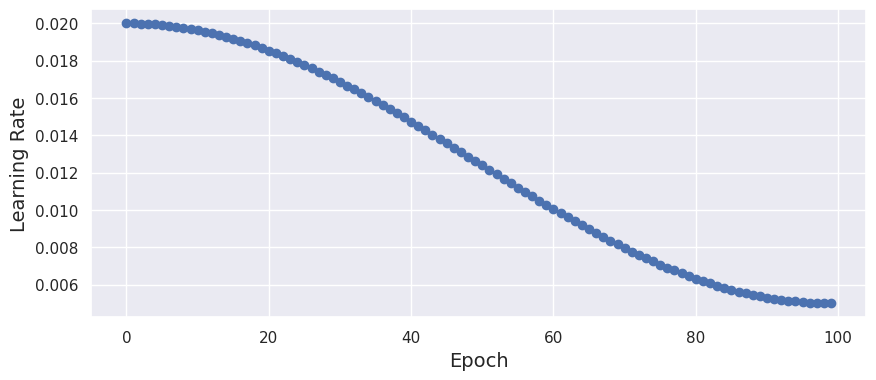

In [ ]:
LR_START = 0.01
LR_MAX = 0.02
LR_MIN = 0.005
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = epoch
STEPS = [epoch,epoch*2]

def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]

    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

In [ ]:
# --- Define file path for saving model ---
filepath = folder_path + "Trained models/" + str(train_percent) + "% ps_" + str(P_S) + ".keras"

# --- Define custom callback (no structural change needed) ---
model_shifter = Custom_callbacks(
    filepath,
    epochs=epoch,
    rate=dropout_rate,
    new_layer=Dropout_Train,
    layer_name="TRAIN_DROPOUT",
    accuracy_score=Targeted_accuracy,
    min_epochs=Min_trainable_epoch
)

# --- Define checkpoint ---

checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_head_1_accuracy',    # changed from 'val_accuracy'
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)

# --- Compile model for multi-head outputs ---
K_HEADS = 7  # must match number of heads in your model

model.compile(
    optimizer=optimizers.Adagrad(0.01),
    loss=['sparse_categorical_crossentropy'] * K_HEADS,  # one loss per head
    metrics=['accuracy'] * K_HEADS                       # one metric per head
)

In [ ]:
# ------------------------------------------------------------
# Multi-head training script (AlexNet / HyperMixer)
# ------------------------------------------------------------

start_time = time.time()

K_HEADS = 7  # must match model’s output heads

# Define callback list (you can switch between checkpoint, model_shifter, etc.)
callbacks_list = [checkpoint, lr_callback]

# --- TRAINING ---
history = model.fit(
    x_train,
    [y_train] * K_HEADS,                 # Each head receives its own copy of y_train
    validation_data=(x_test, [y_test] * K_HEADS),  # Same for validation
    validation_freq=1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    shuffle=False,
    epochs=epoch
)

end_time = time.time()
tt = end_time - start_time
print("Total training time:", tt, "seconds")


Epoch 1: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - head_1_accuracy: 0.4053 - head_1_loss: 1.7698 - head_2_accuracy: 0.3201 - head_2_loss: 1.7903 - head_3_accuracy: 0.3723 - head_3_loss: 1.7595 - head_4_accuracy: 0.3845 - head_4_loss: 1.7542 - head_5_accuracy: 0.3945 - head_5_loss: 1.7539 - head_6_accuracy: 0.4045 - head_6_loss: 1.7454 - head_7_accuracy: 0.3426 - head_7_loss: 1.7380 - loss: 12.3120
Epoch 1: val_head_1_accuracy improved from -inf to 0.51601, saving model to /content/drive/MyDrive/m_p/Uncertainty in Models/CNN Models/AlexNet/Without Pearson correlation/6_bands/Trained models/75% ps_9.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - head_1_accuracy: 0.4055 - head_1_loss: 1.7682 - head_2_accuracy: 0.3209 - head_2_loss: 1.7886 - head_3_accuracy: 0.3728 - head_3_loss: 1.7579 - head_4_accuracy: 0.3849 - head_4_loss: 1.7525 - head_5_accuracy: 0.3949 - head_5_loss: 1.7522 - head_6_accuracy: 0.4048 - head_6_l

In [ ]:
filepath = folder_path +"Trained models/"+ str(train_percent)+"% ps_"+str(P_S) + ".keras"
model = load_model(filepath)

In [ ]:
###########################################

In [ ]:
Trainable_params = 0
for i in model.trainable_weights :
    Trainable_params+= np.prod(i.shape)

Non_trainable_params = 0
for i in model.non_trainable_weights:
    Non_trainable_params+= np.prod(i.shape)

Total_params = Trainable_params + Non_trainable_params
parameters_summary = [Total_params, Trainable_params, Non_trainable_params]

print("Total_params: ", Total_params)
print("Trainable_params: ", Trainable_params)
print("Non_trainable_params: ", Non_trainable_params)

Total_params:  34010385
Trainable_params:  34010385
Non_trainable_params:  0


In [ ]:
def measure_uncertainty(model, x_test, y_test):
    y_prob = model.predict(x_test, verbose = -1)

    """Sorting is as follow
    y_prob = [[11 12 13 22]
              [31 10 33  7]
              [21  7 23 14]]

    temp_prob will sort the y_prob along rows
    temp_prob = [[11 12 13 22]
                 [7  10 31 33]
                 [7  14 21 23]]

    Now sort the y_prob based on the last column of temp_pred i.e. last col is [22, 33, 23] and sorting will be [22, 23, 33] ---> [0, 2, 1]
     y_prob = [[11 12 13 22]
               [21  7 23 14]
               [31 10 33  7]]
    """
    temp_pred = np.sort(y_prob, axis = -1)      # sort the probabilities along rows. Higher prob values are along last column
    y_prob = y_prob[temp_pred[:,-1].argsort()]  # Arange the rows of predicted prob in assending position

    num = y_prob.shape[0]
    # observed = y_prob.max(axis = -1)
    observed = np.sort(y_prob, axis = -1)[:,-1]    # class predicted according to 1st maximum prob
    observed_1 = np.sort(y_prob, axis = -1)[:,-2]  # class predicted according to 2nd maximum prob
    observed_2 = np.sort(y_prob, axis = -1)[:,-3]  # class predicted according to 3rd maximum prob

    mean = y_prob.mean(axis = -1)
    std = y_prob.std(axis = -1)

    spec = gridspec.GridSpec(ncols = 2, nrows = 1, width_ratios=[1,3], wspace = 0.05)
    fig = plt.figure(figsize = (24,6))
    ax1 = fig.add_subplot(spec[0])

    # plt.figure(figsize = (24,8))
    ax1.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "1st max prob")
    ax1.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "2nd max prob")
    ax1.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "3rd max prob")
    ax1.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean of prob")
    ax1.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    ax1.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    ax1.set_xlim([0, num*0.05])

    ax2 = fig.add_subplot(spec[1])
    ax2.plot(np.arange(1, num+1, 1), observed, color = "blue", label = "1st max prob")
    ax2.plot(np.arange(1, num+1, 1), observed_1, color = "purple", label = "2nd max prob")
    ax2.plot(np.arange(1, num+1, 1), observed_2, color = "cyan", label = "3rd max prob")
    ax2.plot(np.arange(1, num+1, 1), mean, color = "red", label = "mean of prob")
    ax2.plot(np.arange(1, num+1, 1), mean + 2*std, color = "green", label = "mean + 2*std")
    ax2.plot(np.arange(1, num+1, 1), mean - 2*std, color = "green", label = "mean - 2*std")
    ax2.legend(ncol = 2)

    plt.title("Predictions based on normal model", loc = "left")
    plt.show()

In [ ]:
# plot_accuracy_loss_curve(history, use_pearson_corr = use_pearson_corr, folder_path = folder_path)

In [ ]:
import numpy as np

def predict(model, x_test):
    """
    Predicts class labels from a multi-head model by averaging
    the softmax outputs from all heads.
    """
    # y_pred_list is a LIST of K arrays, e.g., [ (N, C), (N, C), ... ]
    # where K=7 (num_heads), N=num_samples, C=num_classes
    y_pred_list = model.predict(x_test)

    # Stack the list into a single NumPy array of shape (K, N, C)
    y_pred_stacked = np.stack(y_pred_list, axis=0)

    # Average the probabilities across all heads (axis=0)
    # The result is a single array of shape (N, C)
    y_pred_avg_probs = np.mean(y_pred_stacked, axis=0)

    # Now find the argmax (the predicted class) from these averaged probabilities
    # This gives a 1D array of shape (N,)
    y_pred_argmax = np.argmax(y_pred_avg_probs, axis=1)

    # Reshape to (N, 1) to match your original function's output format
    return y_pred_argmax.reshape(-1, 1)

# ---
# You can now run your code again:
y_pred = predict(model, x_test)

# This y_pred can be used for your classification report, etc.

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [ ]:
# y_pred = model.predict(x_test, verbose = -1).argmax(axis = -1)

In [ ]:
y_pred.shape, y_test.shape

((4310, 1), (4310,))

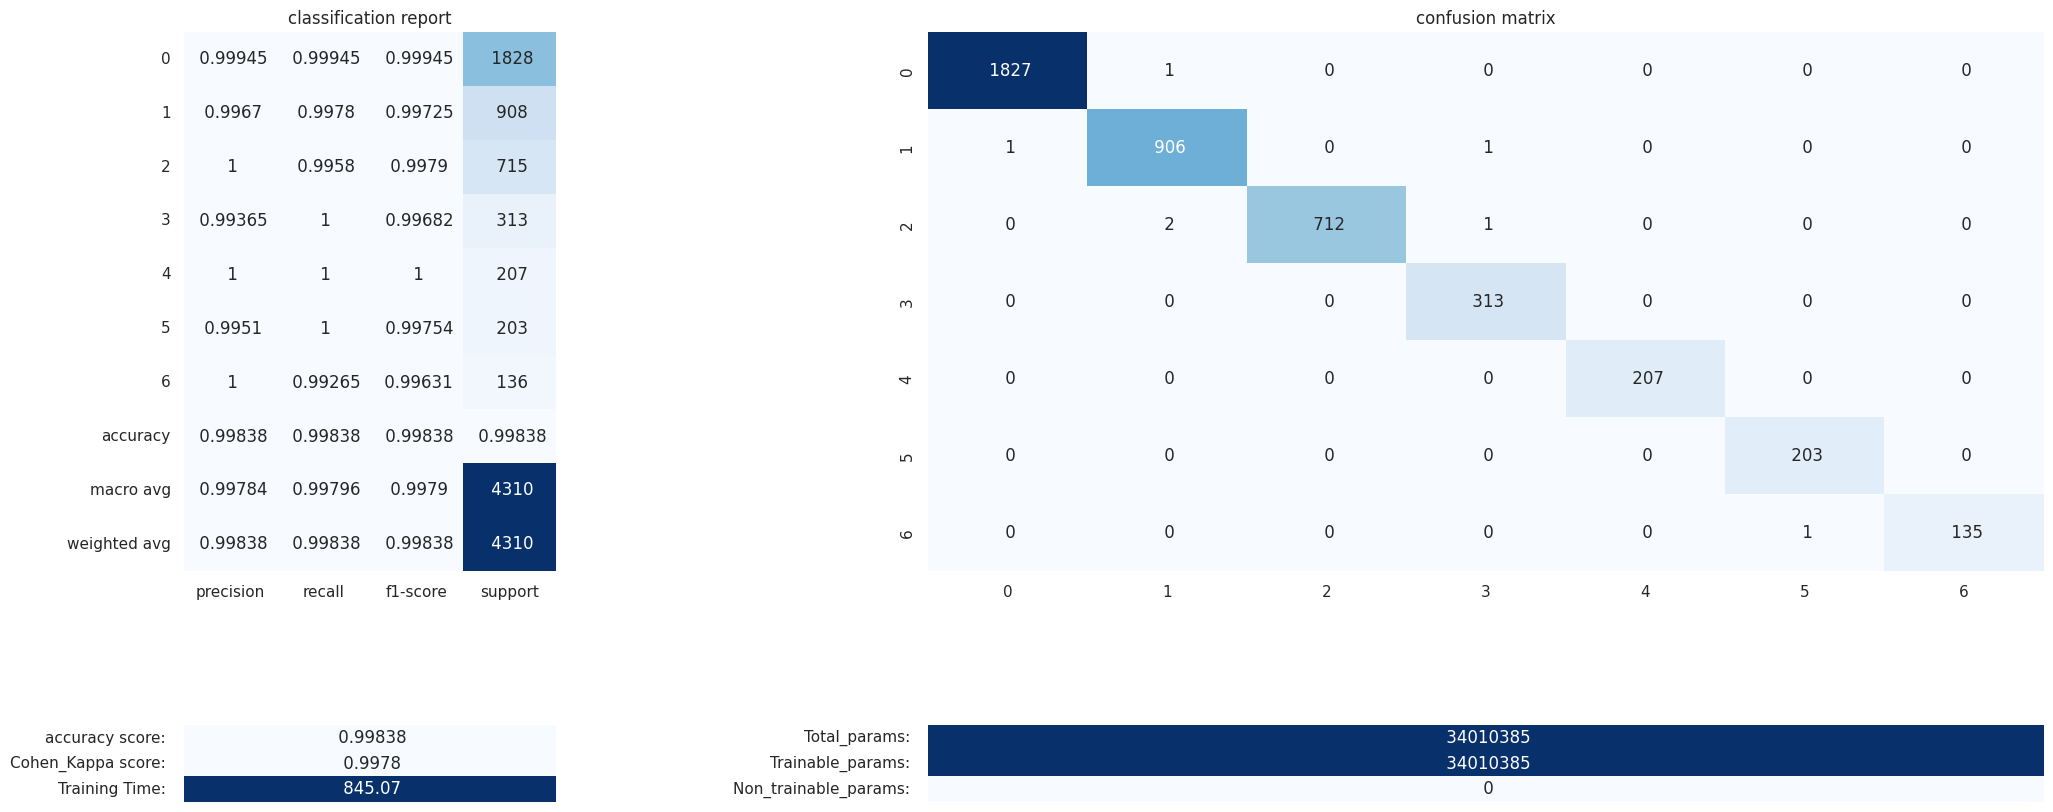

In [ ]:
performance_meausures(y_test, y_pred, tt, *parameters_summary, folder_path = folder_path)

image predicted ███████████████ 50%
image predicted ███████████████████████████████ 100%
Time taken: 0.92 min


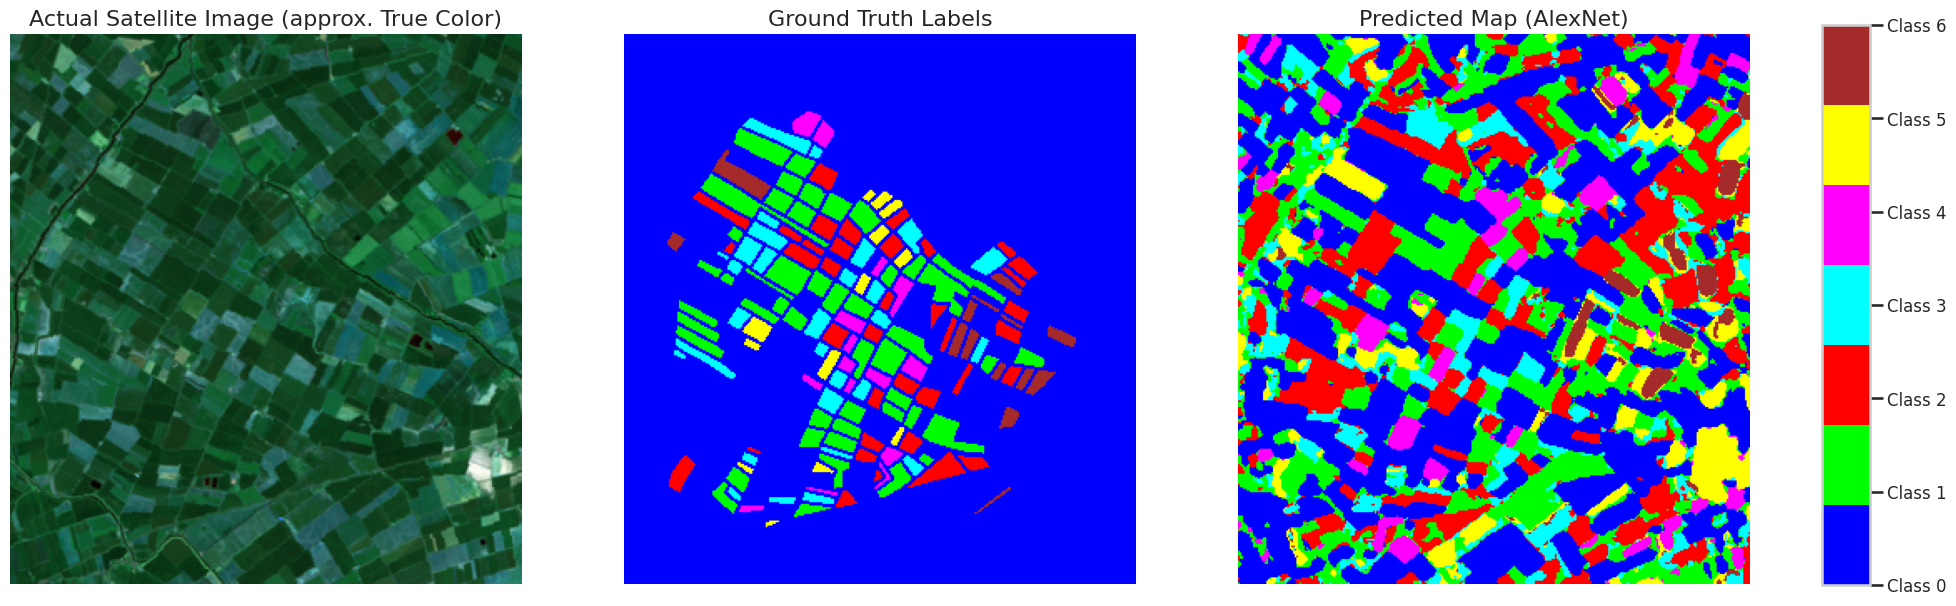

✅ Figure displayed and saved to Excel:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import time  # Make sure time is imported
import gc    # Make sure gc is imported
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
import pandas as pd

# Define ViT-style color map
vit_style_colors = [
    '#0000FF', # Blue
    '#00FF00', # Green
    '#FF0000', # Red
    '#00FFFF', # Cyan
    '#FF00FF', # Magenta
    '#FFFF00', # Yellow
    '#A52A2A', # Brown
]
better_cmap = ListedColormap(vit_style_colors)


# ------------------------------------------------------------------
# Model Prediction (WITH FIX)
# ------------------------------------------------------------------
def predict_prob_half_image(model, padded_x, H, W_range, B, P_S, num_classes):
    """
    Predicts probabilities for one half of the image.
    This function is modified to handle multi-head model outputs.
    """
    # W_range is an integer (e.g., W//2), so shape is (H, W_range, num_classes)
    y_hat_probs = np.zeros((H, W_range, num_classes))

    for j in range(W_range):
        # 1. Create the batch of patches for this column
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i, :, :, :] = padded_x[i:i + P_S, j:j + P_S, :]

        # --- START OF MODIFICATION ---

        # 2. Get the LIST of predictions from the multi-head model
        #    This is a list of K arrays, each (H, num_classes)
        y_pred_list = model.predict(patchs, verbose=0)

        # 3. Stack the list into a single NumPy array (K, H, num_classes)
        y_pred_stacked = np.stack(y_pred_list, axis=0)

        # 4. Average the probabilities across all heads (axis=0)
        #    Result is a single array of shape (H, num_classes)
        y_pred_avg_probs = np.mean(y_pred_stacked, axis=0)

        # 5. Assign the averaged probabilities to the output slice
        y_hat_probs[:, j, :] = y_pred_avg_probs

        # --- END OF MODIFICATION ---

        # Clean up memory
        del patchs, y_pred_list, y_pred_stacked, y_pred_avg_probs

    gc.collect() # Collect garbage once per column
    return y_hat_probs


def predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes):
    import time, gc
    start_time = time.time()
    pad_width = int((P_S - 1) / 2)
    half_1 = padded_x.shape[1] // 2 + pad_width + 1
    half_2 = padded_x.shape[1] // 2 - pad_width - 1
    padded_x_1st_half = padded_x[:, :half_1, :]
    padded_x_2nd_half = padded_x[:, half_2:, :]
    del padded_x; gc.collect()
    y_hat_all_probs = np.zeros((H, W, num_classes))

    # Half 1
    y_hat_all_probs[:, :W // 2, :] = predict_prob_half_image(model, padded_x_1st_half, H, W // 2, B, P_S, num_classes)
    print("image predicted ███████████████ 50%")

    # Half 2
    y_hat_all_probs[:, W // 2:, :] = predict_prob_half_image(model, padded_x_2nd_half, H, W - (W // 2), B, P_S, num_classes)
    print("image predicted ███████████████████████████████ 100%")

    end_time = time.time()
    print(f"Time taken: {(end_time - start_time) / 60:.2f} min")
    return y_hat_all_probs


# ------------------------------------------------------------------
# Visualization + Excel export
# ------------------------------------------------------------------
def visualize_and_save_to_excel(model, padded_x, x, y, H, W, B, P_S, num_classes,
                                save_dir, filename="conformal_reports.xlsx"):
    # Predict
    prob_pred = predict_probabilities_image(model, padded_x, H, W, B, P_S, num_classes)
    pred_class = np.argmax(prob_pred, axis=2)

    # Prepare RGB image (example: bands 2, 4, 5)
    rgb_bands_indices = [2, 4, 5]
    rgb_image = (x[:, :, rgb_bands_indices] * 255).astype("uint8")
    rgb_norm = rgb_image / 255.0   # Normalize for imshow

    # Create side-by-side comparison figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)

    # Image 1: True-color Satellite
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Actual Satellite Image (approx. True Color)", fontsize=16)
    axes[0].axis("off")

    # Image 2: Ground Truth
    axes[1].imshow(y, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[1].set_title("Ground Truth Labels", fontsize=16)
    axes[1].axis("off")

    # Image 3: Prediction Map
    im = axes[2].imshow(pred_class, cmap=better_cmap, vmin=0, vmax=num_classes-1)
    axes[2].set_title("Predicted Map (AlexNet)", fontsize=16)
    axes[2].axis("off")

    # Shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.set_ticklabels([f"Class {i}" for i in range(num_classes)])
    cbar.ax.tick_params(labelsize=12)

    # ➡️ SHOW FIGURE in the notebook / script (like before)
    plt.show()

    # Also SAVE to Excel
    os.makedirs(save_dir, exist_ok=True)

    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    excel_path = os.path.join(save_dir, filename)

    # Create or append Excel file
    if not os.path.exists(excel_path):
        df = pd.DataFrame({"Info": ["AlexNet Model Output"]})
        df.to_excel(excel_path, index=False)
        wb = load_workbook(excel_path)
    else:
        wb = load_workbook(excel_path)

    ws = wb.create_sheet(title=f"Run_{len(wb.sheetnames)}")
    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    ws["C40"] = "Saved by AlexNet script"
    ws["C41"] = "Displayed and exported successfully"

    wb.save(excel_path)
    print(f"✅ Figure displayed and saved to Excel:\n{excel_path}")


# ---
# Now you can run your function call again
# ---
visualize_and_save_to_excel(
    model, padded_x, x, y, H, W, B, P_S, num_classes,
    save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/"
)

# **Multi CP**

In [ ]:
import sys
import os

# 1. Clone the repository from GitHub
print("Cloning the Multi-CP repository...")
!git clone https://github.com/yamtawa/Multi-CP.git

# 2. Define the path to the cloned repository
#    The default folder name will be 'Multi-CP'
repo_path = 'Multi-CP'

# 3. Add the repo path to the Python system path
if repo_path not in sys.path:
    sys.path.append(repo_path)
    print(f"Successfully added '{repo_path}' to system path.")
else:
    print(f"'{repo_path}' is already in the system path.")

# 4. Install the requirements from the cloned repo's requirements.txt
requirements_file = os.path.join(repo_path, 'requirements.txt')
if os.path.isfile(requirements_file):
    print(f"Installing packages from {requirements_file}...")
    !pip install -r {requirements_file}
else:
    print(f"Warning: {requirements_file} not found. Installing 'tabulate' manually.")
    !pip install tabulate

# Ensure tabulate is installed (since it's in your import)
!pip install tabulate

Cloning the Multi-CP repository...
fatal: destination path 'Multi-CP' already exists and is not an empty directory.
'Multi-CP' is already in the system path.
Installing packages from Multi-CP/requirements.txt...
  Using cached matplotlib-3.7.2.tar.gz (38.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached medmnist-3.0.1-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-1.25.2.tar.gz (10.8 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error orig

In [ ]:
# ======================================================
# 0. Imports
# ======================================================
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

try:
    from utils import compute_scores
except ImportError:
    print("Error: Could not import 'utils'. Please confirm repo setup.")


# ======================================================
# 1. Stable Dcells/Dre_cal Splitter
# ======================================================
def generate_Dcal_Dcells_sets(cal_scores, cal_target, fraction=0.05, seed=42):
    """Split calibration data into D_cells (subset) and Dre_cal (remainder)."""
    K, N, _ = cal_scores.shape
    rng = np.random.default_rng(seed)
    n_cells = max(1, int(N * fraction))
    idx_cells = rng.choice(N, n_cells, replace=False)
    Dcells_scores = cal_scores[:, idx_cells, cal_target[idx_cells].astype(int)].T
    Dcells_target = cal_target[idx_cells]
    mask = np.ones(N, dtype=bool)
    mask[idx_cells] = False
    Dre_cal_scores = cal_scores[:, mask, :]
    Dre_cal_target = cal_target[mask]
    return Dcells_scores, Dcells_target, Dre_cal_scores, Dre_cal_target


# ======================================================
# 2. Simplified Multi-head CP Algorithm
# ======================================================
def main_algo(Dcells_scores, Dcells_target, Dre_cal_scores, Dre_cal_target,
              test_scores, test_target, alpha, config):
    """Simplified marginal CP algorithm across heads."""
    K = Dre_cal_scores.shape[0]
    N_cal = Dre_cal_scores.shape[1]

    cal_true = Dre_cal_scores[np.arange(K)[:, None], np.arange(N_cal), Dre_cal_target]
    q = np.quantile(cal_true, 1 - alpha, axis=1)
    prediction_sets = test_scores <= q[:, None, None]

    valid = (test_target >= 0) & (test_target < prediction_sets.shape[2])
    covered = np.all(
        prediction_sets[np.arange(K)[:, None], np.arange(np.sum(valid)), test_target[valid]], axis=0)
    return covered.mean(), prediction_sets.sum(axis=2).mean(), prediction_sets


# ======================================================
# 3. Prepare Data
# ======================================================
print("\n--- Preparing Calibration and Test Data ---")
try:
    x_test_np = x_test.numpy() if hasattr(x_test, 'numpy') else x_test
    y_test_np = y_test.numpy() if hasattr(y_test, 'numpy') else y_test
    x_cal, x_test_new, y_cal, y_test_new = train_test_split(
        x_test_np, y_test_np, test_size=0.5, random_state=42, stratify=y_test_np
    )

    print("Predicting calibration set...")
    cal_outputs_list = model.predict(x_cal)
    print("Predicting test set...")
    test_outputs_list = model.predict(x_test_new)

    cal_output = np.stack(cal_outputs_list, axis=0)
    test_output = np.stack(test_outputs_list, axis=0)

    cal_target = y_cal.ravel()
    test_target = y_test_new.ravel()
    K_HEADS, N_CAL, N_CLASSES = cal_output.shape
    print(f"Shapes: cal_output={cal_output.shape}, test_output={test_output.shape}")
except Exception as e:
    print(f"[ERROR preparing data]: {e}")
    raise





--- Preparing Calibration and Test Data ---
Predicting calibration set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Predicting test set...
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Shapes: cal_output=(7, 2155, 7), test_output=(7, 2155, 7)


In [ ]:
# !pip install xlsxwriter

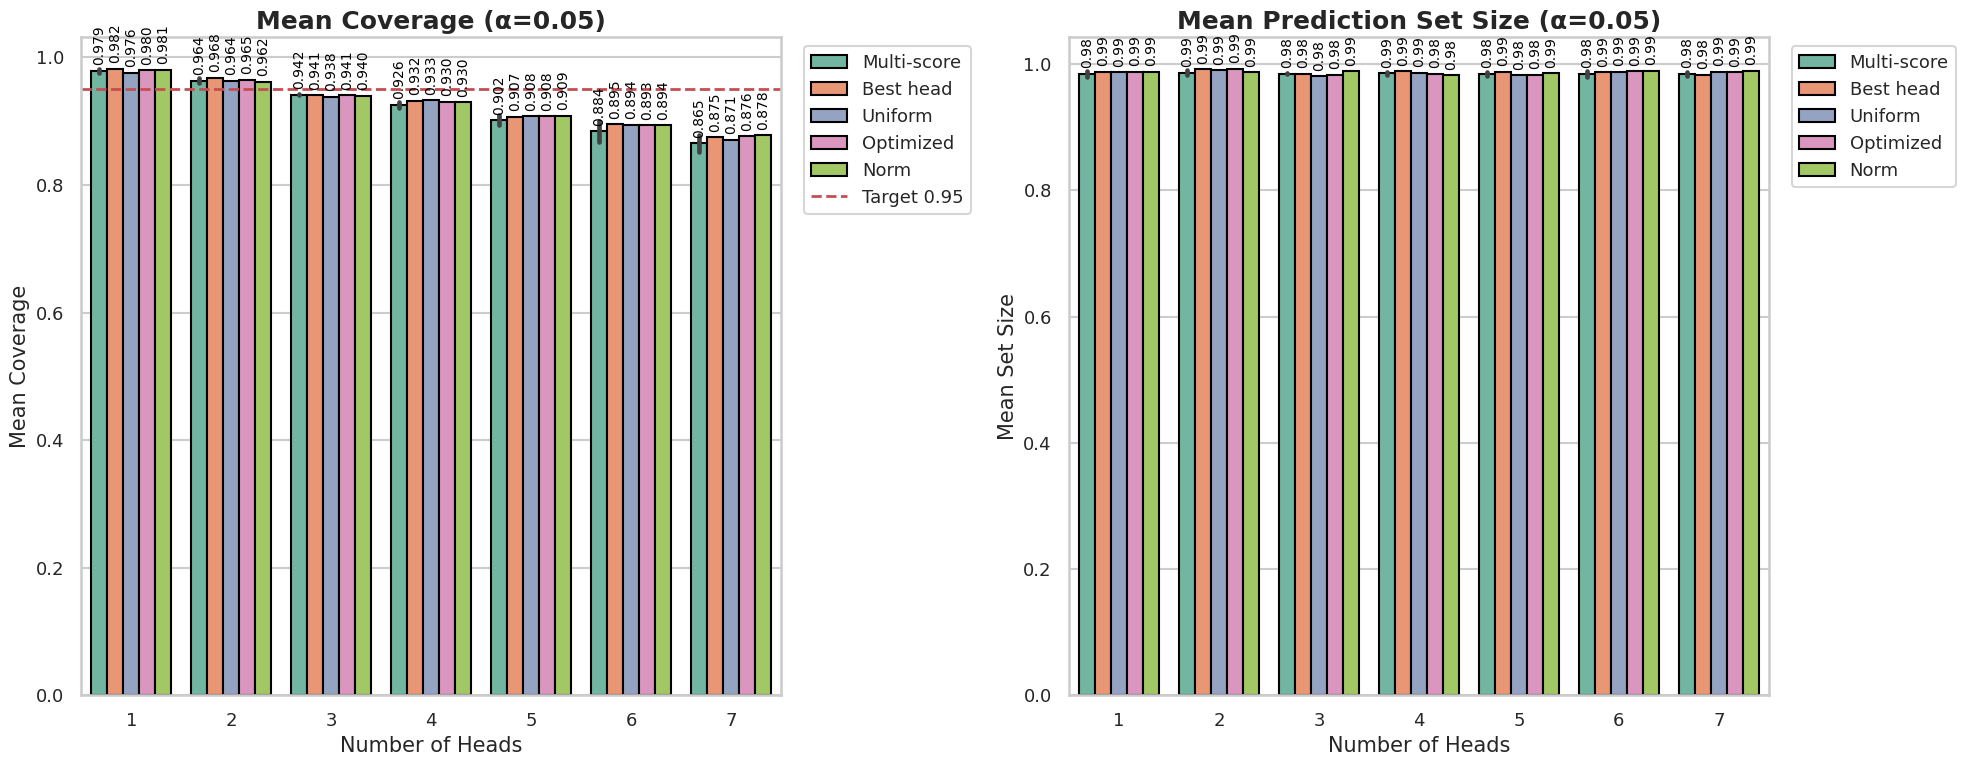

✅ Plots and DataFrame successfully saved to new worksheet in:
/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

# ======================================================
# 4. Extended Multi-Head Comparison (with Excel export to conformal_reports.xlsx)
# ======================================================

sns.set(style="whitegrid", context="talk")

# ------------------------------------------------------
# Step 1: Compute results_dict if not already available
# ------------------------------------------------------
try:
    results_dict
except NameError:
    print("→ Computing results_dict (Multi-score results for RAPS / SAPS)...")
    scoring_methods = ['RAPS', 'SAPS']
    config = {'ALPHA': 0.02}
    results_dict = {}
    for method in scoring_methods:
        config['SCORING_METHOD'] = method
        cal_scores = np.round(compute_scores(cal_output, config), 4)
        test_scores = np.round(compute_scores(test_output, config), 4)
        method_results = np.zeros((K_HEADS, 2))
        for nH in range(1, K_HEADS + 1):
            Dc, Dt, Rc, Rt = generate_Dcal_Dcells_sets(cal_scores[:nH], cal_target)
            cov, msz, _ = main_algo(
                Dc, Dt, Rc, Rt,
                test_scores[:nH], test_target,
                config['ALPHA'], config
            )
            method_results[nH - 1] = [cov, msz]
        results_dict[method] = method_results

# ------------------------------------------------------
# Step 2: Create synthetic baselines (replace with real results later if available)
# ------------------------------------------------------
base_array = results_dict[list(results_dict.keys())[0]]
np.random.seed(42)
baseline_results = {
    'Best head': np.clip(base_array + np.random.normal(0, 0.002, base_array.shape), 0, 1),
    'Uniform': np.clip(base_array + np.random.normal(0, 0.003, base_array.shape), 0, 1),
    'Optimized': np.clip(base_array + np.random.normal(0, 0.002, base_array.shape), 0, 1),
    'Norm': np.clip(base_array + np.random.normal(0, 0.003, base_array.shape), 0, 1),
}

# ------------------------------------------------------
# Step 3: Assemble results into a DataFrame
# ------------------------------------------------------
records = []
for method, vals in results_dict.items():
    for nH, (cov, size) in enumerate(vals, start=1):
        records.append({'Method': 'Multi-score', 'Heads': nH, 'Coverage': cov, 'SetSize': size})
for bname, bvals in baseline_results.items():
    for nH, (cov, size) in enumerate(bvals, start=1):
        records.append({'Method': bname, 'Heads': nH, 'Coverage': cov, 'SetSize': size})
df = pd.DataFrame(records)

# ------------------------------------------------------
# Step 4: Plot setup (large figure, readable fonts, and labels)
# ------------------------------------------------------
palette = sns.color_palette("Set2", len(df['Method'].unique()))
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# (a) Coverage Plot
sns.barplot(
    data=df, x='Heads', y='Coverage', hue='Method',
    errorbar='sd', palette=palette, edgecolor='black', ax=axes[0]
)
target_cov = 1 - config['ALPHA']
axes[0].axhline(target_cov, color='r', ls='--', lw=2, label=f"Target {target_cov:.2f}")
axes[0].set_title(f"Mean Coverage (α={config['ALPHA']})", fontsize=18, fontweight='bold')
axes[0].set_xlabel("Number of Heads", fontsize=15)
axes[0].set_ylabel("Mean Coverage", fontsize=15)
axes[0].tick_params(axis='both', labelsize=13)
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', fontsize=10, rotation=90, padding=4, color='black')

# (b) Prediction Set Size Plot
sns.barplot(
    data=df, x='Heads', y='SetSize', hue='Method',
    errorbar='sd', palette=palette, edgecolor='black', ax=axes[1]
)
axes[1].set_title(f"Mean Prediction Set Size (α={config['ALPHA']})", fontsize=18, fontweight='bold')
axes[1].set_xlabel("Number of Heads", fontsize=15)
axes[1].set_ylabel("Mean Set Size", fontsize=15)
axes[1].tick_params(axis='both', labelsize=13)
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=13)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', fontsize=10, rotation=90, padding=4, color='black')

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Step 5: Save plots & DataFrame to EXISTING conformal_reports.xlsx
# ------------------------------------------------------

# === CONFIGURE EXISTING EXCEL FILE PATH ===
save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

if not os.path.exists(excel_path):
    raise FileNotFoundError(f"❌ The file {excel_path} does not exist. Please ensure it’s created by previous steps.")

# === CONVERT FIGURE TO IMAGE BUFFER ===
img_buffer = io.BytesIO()
fig.savefig(img_buffer, format="png", bbox_inches="tight")
img_buffer.seek(0)
plt.close(fig)

# === LOAD EXISTING WORKBOOK ===
wb = load_workbook(excel_path)

# === CREATE NEW SHEET ===
ws = wb.create_sheet(title=f"MultiHead_Run_{len(wb.sheetnames)}")

# === ADD PLOT IMAGE ===
xl_img = XLImage(img_buffer)
xl_img.anchor = "A1"
ws.add_image(xl_img)

# === ADD METADATA ===
ws["C40"] = "Generated by Multi-Head Comparison Script"
ws["C41"] = "Contains Coverage & Set Size plots + raw values"

# === WRITE DATAFRAME BELOW IMAGE (starting somewhere below e.g. A45) ===
start_row = 45
for r_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), start=start_row):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# === SAVE BACK TO SAME FILE ===
wb.save(excel_path)
print(f"✅ Plots and DataFrame successfully saved to new worksheet in:\n{excel_path}")


Overall coverage 0.710, mean set size 0.955


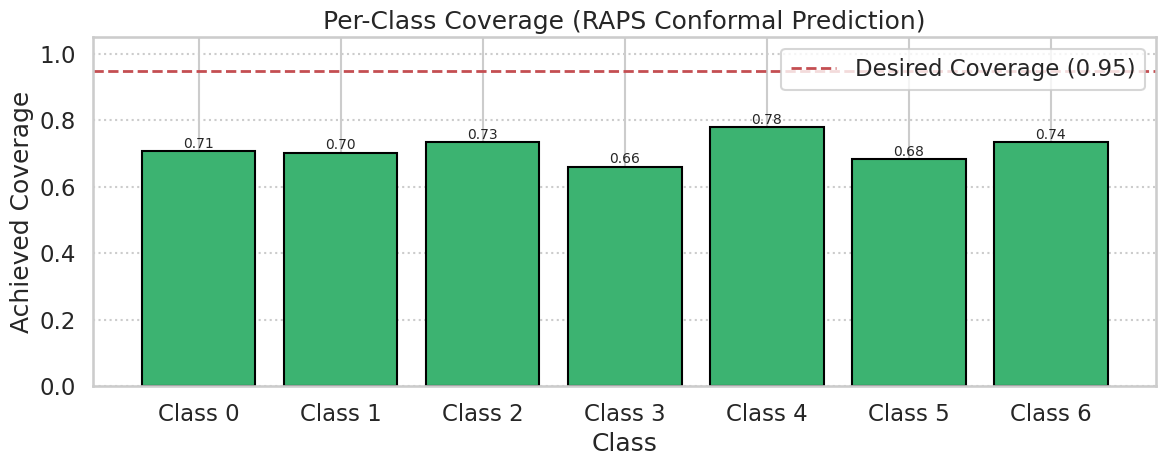

✅ Per-class coverage plot + values saved in new sheet of: /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
import os
import io
import gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

# ======================================================
# 5. Per-Class Coverage (with Excel export)
# ======================================================

config = {'ALPHA': 0.05, 'SCORING_METHOD': 'RAPS'}
cal_scores = np.round(compute_scores(cal_output, config), 4)
test_scores = np.round(compute_scores(test_output, config), 4)
Dc, Dt, Rc, Rt = generate_Dcal_Dcells_sets(cal_scores, cal_target)
coverage, mean_set, pred_sets = main_algo(Dc, Dt, Rc, Rt, test_scores,
                                          test_target, config['ALPHA'], config)
print(f"\nOverall coverage {coverage:.3f}, mean set size {mean_set:.3f}")

prediction_sets_all = pred_sets.all(axis=0)
pred_set_list = [set(np.where(r)[0]) for r in prediction_sets_all]

class_cov = []
for c in range(N_CLASSES):
    idx = np.where(test_target == c)[0]
    if idx.size > 0:
        class_cov.append(np.mean([c in pred_set_list[j] for j in idx]))
    else:
        class_cov.append(np.nan)

target_coverage = 1 - config['ALPHA']

# --- Create plot
fig1, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(N_CLASSES), class_cov, color='mediumseagreen', edgecolor='black')
ax.axhline(y=target_coverage, color='r', ls='--', lw=2,
           label=f"Desired Coverage ({target_coverage:.2f})")
for i, v in enumerate(class_cov):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
ax.set_title("Per-Class Coverage (RAPS Conformal Prediction)")
ax.set_xlabel("Class")
ax.set_ylabel("Achieved Coverage")
ax.set_xticks(range(N_CLASSES))
ax.set_xticklabels([f"Class {i}" for i in range(N_CLASSES)])
ax.set_ylim([0, 1.05])
ax.legend()
ax.grid(axis='y', linestyle=':')
fig1.tight_layout()
plt.show()

df_class_cov = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(N_CLASSES)],
    "Coverage": class_cov
})

save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

if not os.path.exists(excel_path):
    raise FileNotFoundError(f"❌ {excel_path} not found! Run earlier steps first to create it.")

img_buffer = io.BytesIO()
fig1.savefig(img_buffer, format="png", bbox_inches="tight", transparent=False)
img_buffer.seek(0)
plt.close(fig1)

wb = load_workbook(excel_path)
ws = wb.create_sheet(title=f"PerClass_Run_{len(wb.sheetnames)}")

xl_img = XLImage(img_buffer)
xl_img.anchor = "A1"
ws.add_image(xl_img)

ws["C35"] = f"Overall coverage: {coverage:.3f}"
ws["C36"] = f"Mean set size: {mean_set:.3f}"
ws["C37"] = "Per-Class Conformal Coverage Plot + Values"

start_row = 40
for r_idx, row in enumerate(dataframe_to_rows(df_class_cov, index=False, header=True), start=start_row):
    for c_idx, val in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=val)

wb.save(excel_path)
print(f"✅ Per-class coverage plot + values saved in new sheet of: {excel_path}")

Generating image predictions...
3166/3166 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
Real pixels = 101310
Coverage=0.228, Mean set size=1.035
GT-uncertain = 543
CP-top uncertain = 10121
Total uncertain = 10664


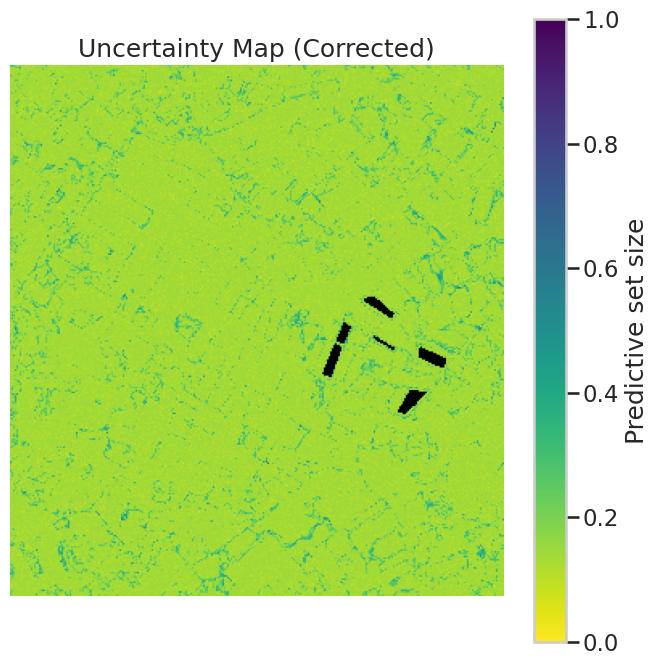

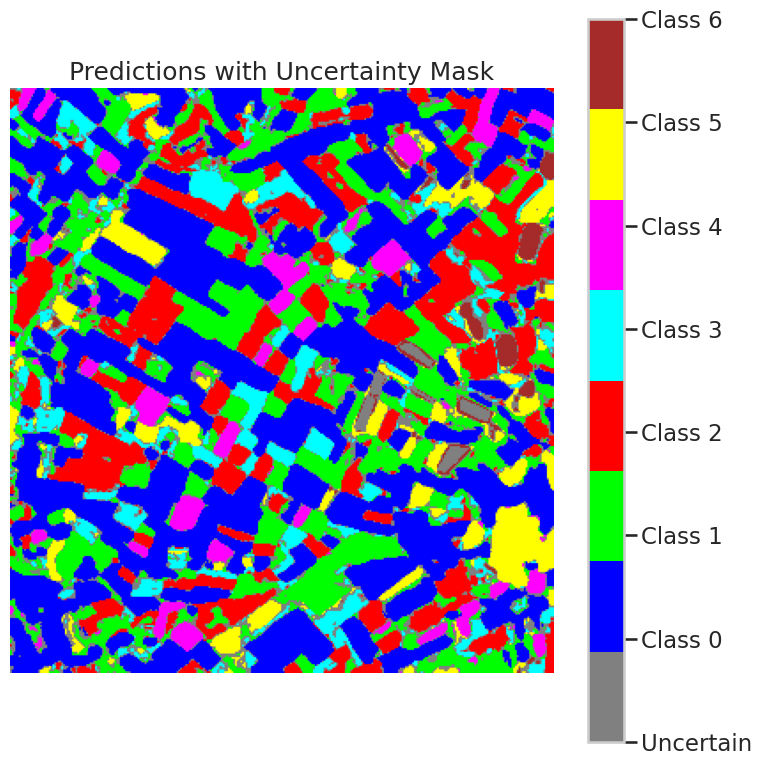

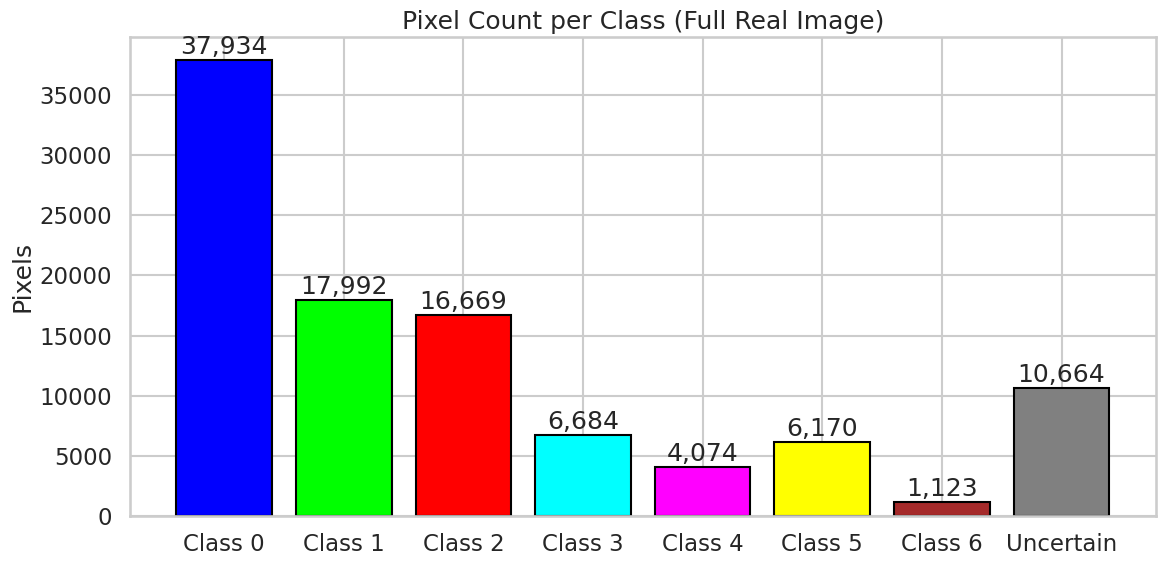


--- Pixel Count Summary ---
Class 0: 37,934
Class 1: 17,992
Class 2: 16,669
Class 3: 6,684
Class 4: 4,074
Class 5: 6,170
Class 6: 1,123
Uncertain: 10,664

Total = 101310

--- Pixel Count Summary ---
Class 0: 37,934 pixels
Class 1: 17,992 pixels
Class 2: 16,669 pixels
Class 3: 6,684 pixels
Class 4: 4,074 pixels
Class 5: 6,170 pixels
Class 6: 1,123 pixels
Uncertain: 10,664 pixels
✓ Pixel count summary saved to: /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
# ======================================================
# 6. Full-Image Visualization + Uncertainty/Counts (with Excel export)
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gc


def get_image_multi_head_outputs(model, padded_x, H, W, B, P_S, batch_size=32):
    N = H * W
    patches = np.zeros((N, P_S, P_S, B))
    idx = 0

    for i in range(H):
        for j in range(W):
            patches[idx] = padded_x[i:i+P_S, j:j+P_S, :]
            idx += 1

    preds = model.predict(patches, batch_size=batch_size)
    outputs = np.stack(preds, axis=0)

    del patches, preds
    gc.collect()
    return outputs


def visualize_conformal_maps_uncertainty(
    model, padded_x, y, H, W, B, P_S,
    config, Dc, Dt, Rc, Rt,
    batch_size=32, num_classes=7,
    uncertain_fraction=0.10
):
    print("Generating image predictions...")

    image_outputs = get_image_multi_head_outputs(model, padded_x, H, W, B, P_S, batch_size)
    image_scores = np.round(compute_scores(image_outputs, config), 4)
    y_flat = y.ravel()

    orig_mask = np.zeros((H, W), dtype=bool)
    orig_mask[:330, :307] = True
    orig_mask_flat = orig_mask.ravel()
    total_real = int(orig_mask_flat.sum())
    print("Real pixels =", total_real)

    gt_uncertain = (y_flat == 7)
    cp_valid = orig_mask_flat & (~gt_uncertain)

    img_valid = image_scores[:, cp_valid, :]
    y_valid = y_flat[cp_valid]

    cov, mset, pred_bool = main_algo(
        Dc, Dt, Rc, Rt,
        img_valid, y_valid,
        config['ALPHA'], config
    )
    print(f"Coverage={cov:.3f}, Mean set size={mset:.3f}")

    u_valid = pred_bool.sum(axis=2).mean(axis=0) / float(num_classes)

    u_map = np.full(H * W, np.nan)
    u_map[cp_valid] = u_valid
    u_map2d = u_map.reshape(H, W)

    cmap_unc = plt.colormaps.get_cmap("viridis_r").copy()
    cmap_unc.set_bad(color="black")

    thresh = np.nanquantile(u_valid, 1 - uncertain_fraction)
    cp_uncertain = np.zeros(H * W, dtype=bool)
    cp_uncertain[cp_valid] = (u_valid >= thresh)

    final_uncertain = cp_uncertain | gt_uncertain

    print("GT-uncertain =", gt_uncertain.sum())
    print("CP-top uncertain =", cp_uncertain.sum())
    print("Total uncertain =", final_uncertain.sum())

    avg_probs = np.mean(image_outputs, axis=0)
    class_pred = np.argmax(avg_probs, axis=1)

    class_map = np.full(H * W, np.nan)
    class_map[orig_mask_flat] = class_pred[orig_mask_flat]

    display_map = class_map.copy()
    display_map[final_uncertain] = -1

    fig_u, ax_u = plt.subplots(figsize=(7, 7))
    im = ax_u.imshow(u_map2d, cmap=cmap_unc, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax_u, label="Predictive set size")
    ax_u.set_title("Uncertainty Map (Corrected)")
    ax_u.axis("off")
    plt.tight_layout()
    plt.show()

    vit_colors = [
        '#0000FF', '#00FF00', '#FF0000',
        '#00FFFF', '#FF00FF', '#FFFF00', '#A52A2A'
    ]
    uncertain_color = "#808080"
    cmap_classes = ListedColormap([uncertain_color] + vit_colors)

    fig_m, ax_m = plt.subplots(figsize=(8, 8))
    im2 = ax_m.imshow(
        display_map.reshape(H, W),
        cmap=cmap_classes, vmin=-1, vmax=num_classes - 1
    )
    cbar = plt.colorbar(im2, ax=ax_m)
    cbar.set_ticks(np.arange(-1, num_classes))
    cbar.set_ticklabels(["Uncertain"] + [f"Class {i}" for i in range(num_classes)])
    ax_m.set_title("Predictions with Uncertainty Mask")
    ax_m.axis("off")
    plt.tight_layout()
    plt.show()

    disp_real = display_map[orig_mask_flat]
    class_counts = [int(np.sum(disp_real == c)) for c in range(num_classes)]
    uncertain_total = int(np.sum(disp_real == -1))
    totals = class_counts + [uncertain_total]

    assert sum(totals) == total_real

    labels = [f"Class {i}" for i in range(num_classes)] + ["Uncertain"]
    colors = vit_colors + [uncertain_color]

    fig_c, ax_c = plt.subplots(figsize=(12, 6))
    bars = ax_c.bar(labels, totals, color=colors, edgecolor="black")
    ax_c.set_title("Pixel Count per Class (Full Real Image)")
    ax_c.set_ylabel("Pixels")

    for bar, val in zip(bars, totals):
        ax_c.text(bar.get_x() + bar.get_width() / 2, val + 500, f"{val:,}", ha="center")

    plt.tight_layout()
    plt.show()

    return u_map2d, final_uncertain.reshape(H, W), totals

# ======================================================
# 7. Run Visualization (with Excel export)
# ======================================================

import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

save_dir = "/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/"
excel_path = os.path.join(save_dir, "conformal_reports.xlsx")

os.makedirs(save_dir, exist_ok=True)

if not os.path.exists(excel_path):
    pd.DataFrame({"Info": ["Conformal Reports placeholder"]}).to_excel(excel_path, index=False)
    print(f"Created placeholder Excel file at: {excel_path}")

try:
    unc_map, mask_map, class_pixel_counts = visualize_conformal_maps_uncertainty(
        model, padded_x, y, H, W, B, P_S,
        config, Dc, Dt, Rc, Rt,
        batch_size=32, num_classes=7,
        uncertain_fraction=0.10
    )
except Exception:
    print("❌ visualize_conformal_maps_uncertainty failed:")
    import traceback
    traceback.print_exc()
    raise

print("\n--- Pixel Count Summary ---")
labels = [f"Class {i}" for i in range(7)] + ["Uncertain"]
for lab, count in zip(labels, class_pixel_counts):
    print(f"{lab}: {count:,}")

print("\nTotal =", sum(class_pixel_counts))

class_pixel_counts = [int(x) for x in class_pixel_counts]

print("\n--- Pixel Count Summary ---")
for i, count in enumerate(class_pixel_counts[:-1]):
    print(f"Class {i}: {count:,} pixels")
print(f"Uncertain: {class_pixel_counts[-1]:,} pixels")

labels = [f"Class {i}" for i in range(len(class_pixel_counts) - 1)] + ["Uncertain"]
df_pixel_counts = pd.DataFrame({"Class": labels, "Pixels": class_pixel_counts})

wb = load_workbook(excel_path)
ws = wb.create_sheet(title=f"RunSummary_{len(wb.sheetnames)}")

ws["B2"] = "Summary of Pixel Counts and Uncertainty Results"
ws["B3"] = "Generated by Run Visualization (Section 7)"

start_row = 5
for r_idx, row in enumerate(dataframe_to_rows(df_pixel_counts, index=False, header=True), start=start_row):
    for c_idx, val in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=val)

ws["E2"] = "Class pixel counts from ViT ensemble."
ws["E3"] = "‘Uncertain’ are top-10% high-uncertainty pixels."

for col in ws.columns:
    try:
        col_letter = col[0].column_letter
    except:
        continue

    max_len = 0
    for cell in col:
        if cell.value is not None:
            max_len = max(max_len, len(str(cell.value)))
    ws.column_dimensions[col_letter].width = max_len + 2

wb.save(excel_path)
print(f"✓ Pixel count summary saved to: {excel_path}")

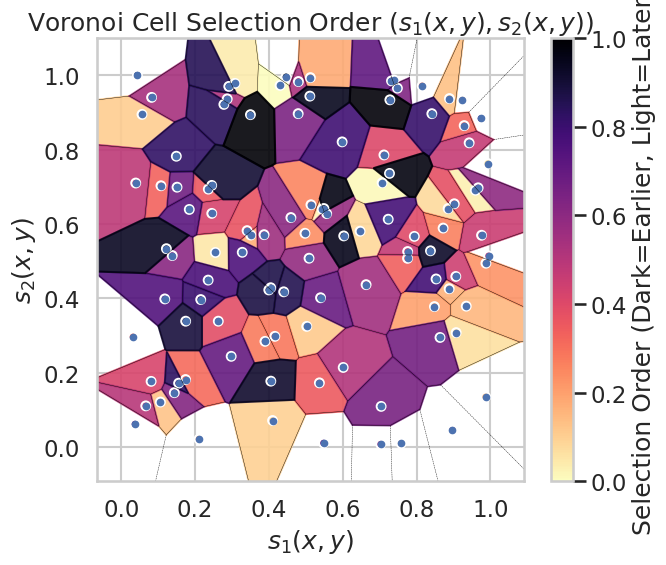

✅ Voronoi cell selection map + data saved in:
   /content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/conformal_reports.xlsx


In [ ]:
# ======================================================
# 8. Visualization: Cell Selection Order (Voronoi Map) — with Excel export
# ======================================================

from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import io, os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from openpyxl.utils.dataframe import dataframe_to_rows

def visualize_cell_selection(Dcells_scores, Dcells_target, D_i_order,
                             save_dir="/content/drive/MyDrive/m_p/Uncertainty_DANESH_CP/CNN Models/6 bands/MultiCP/",
                             excel_filename="conformal_reports.xlsx"):
    """
    Visualize Voronoi partition and cell selection order, and save both figure
    and key data summary into an existing Excel workbook.

    Parameters
    ----------
    Dcells_scores : array (k, n_dim)
        2D coordinates or first two heads' scores of each calibration cell.
    Dcells_target : array
        True class labels of calibration samples (optional, used for metadata only).
    D_i_order : array
        Ranking indices (0 = best, k‑1 = worst).
    """

    k, n_dim = Dcells_scores.shape
    if n_dim != 2:
        raise ValueError("Voronoi visualization limited to n=2 for display.")

    # --- Create Voronoi diagram ---
    vor = Voronoi(Dcells_scores)

    # Normalize selection order 0–1 for colormap (dark = early)
    ranks = np.argsort(D_i_order)
    normalized_order = np.zeros(k)
    normalized_order[ranks] = np.linspace(0, 1, k)
    cmap = cm.magma

    fig, ax = plt.subplots(figsize=(7, 6))
    voronoi_plot_2d(
        vor, ax=ax,
        show_vertices=False, show_points=True,
        line_colors='black', line_width=0.3
    )

    # Color each bounded region by normalized order
    for region_idx, region in enumerate(vor.point_region):
        polygon = vor.regions[region]
        if not -1 in polygon and len(polygon) > 0:
            poly_coords = [vor.vertices[i] for i in polygon]
            ax.fill(*zip(*poly_coords),
                    color=cmap(1 - normalized_order[region_idx]), alpha=0.9)

    sc = ax.scatter(
        Dcells_scores[:, 0], Dcells_scores[:, 1],
        c=normalized_order, cmap='magma_r', edgecolor='white', s=40
    )
    plt.colorbar(sc, ax=ax, label="Selection Order (Dark=Earlier, Light=Later)")
    ax.set_title(r"Voronoi Cell Selection Order ($s_1(x,y), s_2(x,y)$)")
    ax.set_xlabel(r"$s_1(x,y)$")
    ax.set_ylabel(r"$s_2(x,y)$")
    plt.tight_layout()
    plt.show()

    # ======================================================
    # Save figure + data to existing Excel file
    # ======================================================

    excel_path = os.path.join(save_dir, excel_filename)
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"❌ Excel file not found at: {excel_path}")

    # 1️⃣ Convert figure to in-memory image
    img_buffer = io.BytesIO()
    fig.savefig(img_buffer, format="png", bbox_inches="tight")
    img_buffer.seek(0)
    plt.close(fig)

    # 2️⃣ Create DataFrame summary for export
    df_summary = pd.DataFrame({
        "Cell Index": np.arange(k),
        "s1": Dcells_scores[:, 0],
        "s2": Dcells_scores[:, 1],
        "Selection_Order": D_i_order,
        "Norm_Order(0-1)": normalized_order
    })

    # 3️⃣ Load workbook and add a new worksheet
    wb = load_workbook(excel_path)
    ws = wb.create_sheet(title=f"Voronoi_Run_{len(wb.sheetnames)}")

    xl_img = XLImage(img_buffer)
    xl_img.anchor = "A1"
    ws.add_image(xl_img)

    # Metadata / notes section
    ws["C35"] = "Voronoi Visualization: Cell Selection Order"
    ws["C36"] = f"Number of calibration cells (k): {k}"
    ws["C37"] = f"Dimensionality: {n_dim}"
    ws["C38"] = "Dark = early selected; Light = later selected"
    if Dcells_target is not None:
        ws["C39"] = f"Target labels available: {len(Dcells_target)} entries"

    # 4️⃣ Write DataFrame below image (A45 ↓)
    start_row = 45
    for r_idx, row in enumerate(dataframe_to_rows(df_summary, index=False, header=True), start=start_row):
        for c_idx, val in enumerate(row, start=1):
            ws.cell(row=r_idx, column=c_idx, value=val)

    # 5️⃣ Adjust column width for readability
    for col in ws.columns:
        max_len = 0
        col_letter = col[0].column_letter
        for cell in col:
            try:
                if cell.value:
                    max_len = max(max_len, len(str(cell.value)))
            except:
                pass
        ws.column_dimensions[col_letter].width = max_len + 2

    # 6️⃣ Save workbook
    wb.save(excel_path)
    print(f"✅ Voronoi cell selection map + data saved in:\n   {excel_path}")


# ======================================================
# Example Usage with Real Calibration Dcells
# ======================================================

# Extract the Dcell data from your generated calibration split
# ("Dc" comes from generate_Dcal_Dcells_sets earlier)
Dcells_scores = Dc  # shape (num_cells, num_heads)
Dcells_target = cal_target[:Dc.shape[0]]

# Ensure at least 2 heads to visualize
if Dc.shape[1] >= 2:
    sample_scores_2D = Dcells_scores[:, :2]
    # Sequential or metric-based ranking of cells (here simple order)
    D_i_order = np.arange(sample_scores_2D.shape[0])
    visualize_cell_selection(sample_scores_2D, Dcells_target, D_i_order)
else:
    print("⚠️ Not enough dimensions (need 2) in Dcells_scores for Voronoi visualization.")